###  Get variance for each amt labeled sentence
> Variance for each (word pair, sentence pair) of each method (e.g., variance among 200 trees in RF).

#### 0 Randomly select 90% of the whole data to fit the following methods and repeat to get variance
#### 1 VT-RF variance
> 1.1 Fit VT-RF with all sentences containing source and target except the current one <br>
> 1.2 Get path for source sentence and target sentence, each tree has a path, 200 trees in total, path with max and min probability <br>
> 1.3 Compute treatment effect of each pair of sentence, get variance for source and target sentence separately <br>

#### 2 CTF-RF variance
> 2.1 Fit source RF with all sentences containing source word, target RF with all sentences containing target word, except current one <br>
> 2.2 Get path for source sentence and target sentence, path with max and min probability <br>
> 2.3 Compute treatment effect of each pair of sentence, get variance for source and target sentence separately <br>

#### 3 CSF variance
> 3.1 Fit causal forest and get variance directly <br>

In [1]:
import pickle, pydot, random, re, time
import pandas as pd
import numpy as np
from scipy.sparse import vstack
from sklearn.externals.six import StringIO  
from sklearn.datasets import load_iris
from sklearn import tree
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

In [2]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects import Matrix
import rpy2.robjects.numpy2ri
from rpy2.robjects.vectors import Matrix
from rpy2.robjects.packages import importr
importr('grf')
rpy2.robjects.numpy2ri.activate()
import warnings
warnings.filterwarnings("ignore")

In [3]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'
amt_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/6_amt/'
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}

In [4]:
def fit_KNN(X_src_tf,src_smp_lbs,X_tar_tf,tar_smp_lbs,X_test_tf,src_wdi_tf,tar_wdi_tf):
    """
    Get 30 neighbors from target sentences, and 30 from source sentences, take difference to get treatment effect.
    """
    X_test_tf_ = X_test_tf[:]
    X_test_tf_[:,src_wdi_tf]=0
    
    src_sim = cosine_similarity(X_test_tf_,X_src_tf)
    tar_sim = cosine_similarity(X_test_tf_,X_tar_tf)

    KNN_srcp = []
    KNN_tarp = []
    KNN_effects = []
    for i in range(X_test_tf_.shape[0]):
        src_neighbor_idx = src_sim[i].argsort()[::-1][:min(30,len(src_sim[i]))]
        src_neighbor_labels = [src_smp_lbs[idx] for idx in src_neighbor_idx]

        tar_neighbor_idx = tar_sim[i].argsort()[::-1][:min(30,len(tar_sim[i]))]
        tar_neighbor_labels = [tar_smp_lbs[idx] for idx in tar_neighbor_idx]
        
        KNN_srcp.append(float('%.3f' % (np.mean(src_neighbor_labels))))
        KNN_tarp.append(float('%.3f' % (np.mean(tar_neighbor_labels))))
        KNN_effects.append(float('%.3f' % (np.mean(tar_neighbor_labels) - np.mean(src_neighbor_labels))))
        
    return KNN_srcp,KNN_tarp,KNN_effects

In [5]:
def fit_VTRF(X_src_ct,src_smp_lbs,X_tar_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct):
    """
    Fit one random forest using both source and target sentences.
    Make virtual twins for test instances.
    Predict for test instances and virtual instances, take difference as treatment effects.
    """
    X_train = vstack((X_src_ct,X_tar_ct))
    Y_train = list(src_smp_lbs) + list(tar_smp_lbs)
    
    RF_clf = RandomForestClassifier(n_estimators = min(200,X_train.shape[0]), max_features='log2', min_samples_leaf=2, 
                                        random_state=42, n_jobs=-1, oob_score=True)
    RF_clf.fit(X_train, Y_train)
    
    # create virtual twins for test instances
    X_test_vt = X_test_ct[:]
    X_test_vt[:,src_wdi_ct] = 0
    X_test_vt[:,tar_wdi_ct] = 1
    
    # Take difference as treatment effect
    vt_pred = np.array(RF_clf.predict_proba(X_test_vt)[:,list(RF_clf.classes_).index(1)])
    src_pred = np.array(RF_clf.predict_proba(X_test_ct)[:,list(RF_clf.classes_).index(1)])
        
    return [float('%.3f' % (src_e)) for src_e in src_pred],[float('%.3f' % (tar_e)) for tar_e in vt_pred],[float('%.3f' % (effect)) for effect in vt_pred-src_pred]

In [6]:
def fit_CFRF(X_src_ct,src_smp_lbs,X_tar_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct):
    """
    Fit one source random forest using source sentences and one target random forest using target sentences.
    Make virtual twins for test instances.
    Predict for test instances using source random forest, and predict for virtual instances using target random forest.
    Take difference as treatment effects.
    """
    src_RF_clf = RandomForestClassifier(n_estimators = min(200,X_src_ct.shape[0]), max_features='log2', min_samples_leaf=2, 
                                        random_state=42, n_jobs=-1, oob_score=True)
    tar_RF_clf = RandomForestClassifier(n_estimators = min(200,X_tar_ct.shape[0]), max_features='log2', min_samples_leaf=2, 
                                        random_state=42, n_jobs=-1, oob_score=True)

    src_RF_clf.fit(X_src_ct, src_smp_lbs)
    tar_RF_clf.fit(X_tar_ct, tar_smp_lbs)
    
    # create virtual twins for test instances
    X_test_vt = X_test_ct[:]
    X_test_vt[:,src_wdi_ct] = 0
    X_test_vt[:,tar_wdi_ct] = 1

    vt_pred = np.array(tar_RF_clf.predict_proba(X_test_vt)[:,list(tar_RF_clf.classes_).index(1)])
    src_pred = np.array(src_RF_clf.predict_proba(X_test_ct)[:,list(src_RF_clf.classes_).index(1)])
        
    return [float('%.3f' % (src_e)) for src_e in src_pred],[float('%.3f' % (tar_e)) for tar_e in vt_pred],[float('%.3f' % (effect)) for effect in vt_pred-src_pred]

In [7]:
def fit_CSF(X_src_ct,src_smp_lbs,X_tar_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct):
    """
    Fit one causal forest, set treatment variable values.
    Calculate treatment effect directly.
    """
    X_test_arr = X_test_ct.toarray()
    R_test_ct = r.matrix(X_test_arr, nrow=X_test_arr.shape[0], ncol=X_test_arr.shape[1])
    train_vec = vstack((X_src_ct,X_tar_ct)).toarray()
    R_train_vec = r.matrix(train_vec, nrow=train_vec.shape[0], ncol=train_vec.shape[1])
    R_train_y = list(src_smp_lbs) + list(tar_smp_lbs)
    R_train_w = list(np.zeros(len(src_smp_lbs))) + list(np.ones(len(tar_smp_lbs)))
    
    r.assign('X.train',R_train_vec)
    r.assign('X.test',R_test_ct)
    r.assign('Y',ro.FloatVector(R_train_y))
    r.assign('W',ro.IntVector(R_train_w))
    
    r('c.src_forest200 <- causal_forest(X.train,Y,W, num.trees=200, num.threads=8, seed=set.seed(10),precompute.nuisance = FALSE)')
    r('c.pred_src200 <- predict(c.src_forest200, X.test, num.threads=8, estimate.variance = TRUE)')

    r('c.src_forest2000 <- causal_forest(X.train,Y,W, num.trees=2000, num.threads=8, seed=set.seed(10),precompute.nuisance = FALSE)')
    r('c.pred_src2000 <- predict(c.src_forest2000, X.test, num.threads=8, estimate.variance = TRUE)')

    
    CSF_pred_200 = [float('%.3f' % (pred)) for pred in r('c.pred_src200')[0]]
    CSF_var_200 = [float('%.3f' % (var)) for var in r('c.pred_src200')[1]]
    CSF_pred_2000 = [float('%.3f' % (pred)) for pred in r('c.pred_src2000')[0]]
    CSF_var_2000 = [float('%.3f' % (var)) for var in r('c.pred_src2000')[1]]
    
    return CSF_pred_200,CSF_var_200,CSF_pred_2000,CSF_var_2000
    #return r('c.pred_src200'),r('c.pred_src2000')

In [8]:
def get_containing_sents(word_pair,data_file):
    """
    Get all sentences containing source word and target word
    """
    data_pd = pd.DataFrame(pickle.load(open(data_file,'rb')))
    src_tar_pd = data_pd[(data_pd.source == word_pair[0]) & (data_pd.target == word_pair[1])]
    tar_src_pd = data_pd[(data_pd.source == word_pair[1]) & (data_pd.target == word_pair[0])]
    
    src_sents = []
    for sent in src_tar_pd.sentence.values:
        src_sents.append(re.sub('-RRB-',')',re.sub('-LRB-','(',sent)))
        
    tar_sents = []
    for sent in tar_src_pd.sentence.values:
        tar_sents.append(re.sub('-RRB-',')',re.sub('-LRB-','(',sent)))
        
    return src_sents, list(src_tar_pd.true_y.values), tar_sents, list(tar_src_pd.true_y.values)

In [9]:
def vectorize_sents(src_sents,tar_sents,current_sents,my_vocab):
    if(len(my_vocab)>0):
        ct_vec = CountVectorizer(min_df=3,binary=True,vocabulary=my_vocab)
        tfidf_vec = TfidfVectorizer(norm='l2',vocabulary=my_vocab)
    else:
        ct_vec = CountVectorizer(min_df=3,binary=True)
        tfidf_vec = TfidfVectorizer(norm='l2')
    
    X_ct = ct_vec.fit_transform(src_sents+tar_sents+current_sents)
    X_tfidf = tfidf_vec.fit_transform(src_sents+tar_sents+current_sents)
    return X_ct[:len(src_sents)],X_ct[len(src_sents):X_ct.shape[0]-len(current_sents)],X_ct[-len(current_sents):], X_tfidf[:len(src_sents)],X_tfidf[len(src_sents):X_tfidf.shape[0]-len(current_sents)],X_tfidf[-len(current_sents):], ct_vec.vocabulary_, tfidf_vec.vocabulary_    

In [10]:
def get_samples(X_ct,X_tf,labels,perct):
    smp_idx = random.sample(range(X_ct.shape[0]),int(X_ct.shape[0]*perct))
    X_smp_ct = X_ct[smp_idx]
    X_smp_tf = X_tf[smp_idx]
    smp_lbs = [labels[idx] for idx in smp_idx]
    return X_smp_ct,X_smp_tf,smp_lbs

In [11]:
def compute_variance(amt_path,data_file,vocab_file,n_repeat,perct):
    """
    Get containing sentences for each word pair, and exclude the 3 sentences present in file.
    Select 90% of containing sentences as training instances, fit model and return prediction, repeat for 100 times.
    Compute variance using 100 repeated predictions.
    """
    for dataset in ['yp','tw','airbnb']:
        if(dataset != 'airbnb'):
            continue
        amt_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')

        all_info = []
        for wdpair, row in amt_pd.groupby(['source','target']):
            print(wdpair)
            
            # Step 1, get all containing sentences
            current_sents = list(row.src_sentence.values)
            all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents(wdpair,data_file[dataset])
            
            # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
            current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
            src_train_sents = []
            src_train_labels = []
            for i in range(len(all_src_sents)):
                if(i not in current_ids):
                    src_train_sents.append(all_src_sents[i])
                    src_train_labels.append(all_src_labels[i])

            # Vectorize sentences
            if(dataset == 'airbnb'):
                my_vocab = list(set(pd.read_csv(vocab_file).word.values))
            else:
                my_vocab = []

            X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vocab,tf_vocab = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

            #return X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf
            src_wdi_ct = ct_vocab[wdpair[0]]
            src_wdi_tf = tf_vocab[wdpair[0]]
            tar_wdi_ct = ct_vocab[wdpair[1]]
            tar_wdi_tf = tf_vocab[wdpair[1]]

            # Step 3: select 90% as training samples to fit different models and predict for testing data, repeat for 100 times
            KNN_src = []
            KNN_tar = []
            KNN_effect = []
            VTRF_src = []
            VTRF_tar = []
            VTRF_effect = []
            CFRF_src = []
            CFRF_tar = []
            CFRF_effect = []
            CSF_effect200 = []
            CSF_effect2000 = []

            for i in range(n_repeat):
                """
                Separate sample selection for source and target, to keep source and target in same ratio.
                """
                X_src_smp_ct,X_src_smp_tf,src_smp_lbs = get_samples(X_src_ct,X_src_tf,src_train_labels,perct)
                X_tar_smp_ct,X_tar_smp_tf,tar_smp_lbs = get_samples(X_tar_ct,X_tar_tf,all_tar_labels,perct)

                KNN_srcp,KNN_tarp,KNN_eft = fit_KNN(X_src_smp_tf,src_smp_lbs,X_tar_smp_tf,tar_smp_lbs,X_test_tf,src_wdi_tf,tar_wdi_tf)
                KNN_src.append(KNN_srcp)
                KNN_tar.append(KNN_tarp)
                KNN_effect.append(KNN_eft)
                VT_src,VT_tar,VT_effect = fit_VTRF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
                VTRF_src.append(VT_src)
                VTRF_tar.append(VT_tar)
                VTRF_effect.append(VT_effect)
                CTF_src,CTF_tar,CTF_effect = fit_CFRF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
                CFRF_src.append(CTF_src)
                CFRF_tar.append(CTF_tar)
                CFRF_effect.append(CTF_effect)
#                 rpred200,rpred2000 = fit_CSF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
#                 return rpred200, rpred2000
                pred200,var200,pred2000,var2000 = fit_CSF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
                CSF_effect200.append(pred200)
                CSF_effect2000.append(pred2000)

            # Step 4: calculate variance using repeated predictions.

            CSF_direct_pred200,CSF_direct_var200, CSF_direct_pred2000,CSF_direct_var2000 = fit_CSF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)

            for i in range(row.shape[0]):
                new_info = row.iloc[i].to_dict()
                new_info['n_src'] = len(all_src_sents)
                new_info['n_tar'] = len(all_tar_sents)
                new_info['KNN_srcp'] = list(np.array(KNN_src)[:,i])
                new_info['KNN_tarp'] = list(np.array(KNN_tar)[:,i])
                new_info['KNN_var'] = list(np.array(KNN_effect)[:,i])
                new_info['VTRF_srcp'] = list(np.array(VTRF_src)[:,i])
                new_info['VTRF_tarp'] = list(np.array(VTRF_tar)[:,i])
                new_info['VTRF_var'] = list(np.array(VTRF_effect)[:,i])
                new_info['CFRF_srcp'] = list(np.array(CFRF_src)[:,i])
                new_info['CFRF_tarp'] = list(np.array(CFRF_tar)[:,i])
                new_info['CFRF_var'] = list(np.array(CFRF_effect)[:,i])
                new_info['CSF_pred_var200'] = list(np.array(CSF_effect200)[:,i])
                new_info['CSF_pred_var2000'] = list(np.array(CSF_effect2000)[:,i])
                new_info['CSF_direct_var200'] = CSF_direct_var200[i]
                new_info['CSF_direct_var2000'] = CSF_direct_var2000[i]

                all_info.append(new_info)
            

        pd.DataFrame(all_info).to_csv(project_path+'V2_'+full_name[dataset].lower()+'/8_Var/'+dataset+'_effect_var_prob4.csv',
        columns = list(amt_pd.columns)+['n_src','n_tar','KNN_srcp','KNN_tarp','KNN_var','VTRF_srcp','VTRF_tarp','VTRF_var','CFRF_srcp','CFRF_tarp','CFRF_var','CSF_pred_var200','CSF_pred_var2000','CSF_direct_var200','CSF_direct_var2000'],
                                      index = False)   

In [12]:
data_file = {}
data_file['yp'] = project_path + 'V2_yelp/5_Select/yp_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['tw'] = project_path + 'V2_twitter/5_Select/tw_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['airbnb'] = project_path + 'V2_airbnb/5_Select/airbnb_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit_limitvocab.pickle'

vocab_file = project_path + 'V2_airbnb/0_Data/common_wds.csv'
#effect_var_file = project_path+'V2_yelp/8_Var/yp_effect_var.csv'
start = time.time()
compute_variance(amt_path,data_file,vocab_file,n_repeat=100,perct=0.85)
end = time.time()
print((end-start)/60)

('amazing', 'fabulous')
('amazing', 'fantastic')
('amazing', 'incredible')
('amazing', 'outstanding')
('amazing', 'spectacular')
('amazing', 'wonderful')
('apartment', 'condo')
('apartments', 'homes')
('best', 'nicest')
('cheap', 'inexpensive')
('comfortable', 'cozy')
('dynamic', 'vibrant')
('events', 'festivals')
('exciting', 'fabulous')
('exciting', 'interesting')
('exciting', 'spectacular')
('exciting', 'stunning')
('famous', 'big')
('famous', 'excellent')
('famous', 'grand')
('famous', 'old')
('famous', 'renowned')
('famous', 'special')
('famous', 'wonderful')
('hot', 'excellent')
('huge', 'spectacular')
('nice', 'gorgeous')
('notable', 'unique')
('open', 'outstanding')
('predominantly', 'especially')
('predominantly', 'mostly')
('rapidly', 'quickly')
('square', 'plaza')
('store', 'boutique')
('trips', 'tours')
('various', 'several')
('yummy', 'delicious')
('yummy', 'good')
394.30571784178414


In [11]:
def compute_variance(amt_path,data_file,vocab_file,dataset,n_repeat,perct):
    """
    Get containing sentences for each word pair, and exclude the 3 sentences present in file.
    Select 90% of containing sentences as training instances, fit model and return prediction, repeat for 100 times.
    Compute variance using 100 repeated predictions.
    """
    
    amt_pd = pd.read_csv(amt_path+'results/airbnb_result_summary_nodummy.csv')

    all_info = []
    for wdpair, row in amt_pd.groupby(['source','target']):
        print(wdpair)
        # Step 1, get all containing sentences
        current_sents = list(row.src_sentence.values)
        all_src_sents, all_src_labels, all_tar_sents, all_tar_labels = get_containing_sents(wdpair,data_file)

        # Step 2: exclude current sentences from containing sentences, for out-of-bag prediction.
        current_ids = [all_src_sents.index(cur_sent) for cur_sent in current_sents]
        src_train_sents = []
        src_train_labels = []
        for i in range(len(all_src_sents)):
            if(i not in current_ids):
                src_train_sents.append(all_src_sents[i])
                src_train_labels.append(all_src_labels[i])

        # Vectorize sentences
        if(dataset == 'airbnb'):
            my_vocab = list(set(pd.read_csv(vocab_file).word.values))
        else:
            my_vocab = []

        X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf,ct_vocab,tf_vocab = vectorize_sents(src_train_sents,all_tar_sents,current_sents,my_vocab)

        #return X_src_ct,X_tar_ct,X_test_ct,X_src_tf,X_tar_tf,X_test_tf
        src_wdi_ct = ct_vocab[wdpair[0]]
        src_wdi_tf = tf_vocab[wdpair[0]]
        tar_wdi_ct = ct_vocab[wdpair[1]]
        tar_wdi_tf = tf_vocab[wdpair[1]]

        # Step 3: select 90% as training samples to fit different models and predict for testing data, repeat for 100 times
        KNN_pred = []
        VTRF_pred = []
        CFRF_pred = []
        CSF_pred200 = []
        CSF_pred2000 = []

        for i in range(n_repeat):
            X_src_smp_ct,X_src_smp_tf,src_smp_lbs = get_samples(X_src_ct,X_src_tf,src_train_labels,perct)
            X_tar_smp_ct,X_tar_smp_tf,tar_smp_lbs = get_samples(X_tar_ct,X_tar_tf,all_tar_labels,perct)

            KNN_pred.append(fit_KNN(X_src_smp_tf,src_smp_lbs,X_tar_smp_tf,tar_smp_lbs,X_test_tf,src_wdi_tf,tar_wdi_tf))
            VTRF_pred.append(fit_VTRF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct))
            CFRF_pred.append(fit_CFRF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct))
            pred200,var200,pred2000,var2000 = fit_CSF(X_src_smp_ct,src_smp_lbs,X_tar_smp_ct,tar_smp_lbs,X_test_ct,src_wdi_ct,tar_wdi_ct)
            CSF_pred200.append(pred200)
            CSF_pred2000.append(pred2000)

        # Step 4: calculate variance using repeated predictions.

        CSF_direct_pred200,CSF_direct_var200, CSF_direct_pred2000,CSF_direct_var2000 = fit_CSF(X_src_ct,src_train_labels,X_tar_ct,all_tar_labels,X_test_ct,src_wdi_ct,tar_wdi_ct)

        for i in range(row.shape[0]):
            new_info = row.iloc[i].to_dict()
            new_info['n_src'] = len(all_src_sents)
            new_info['n_tar'] = len(all_tar_sents)
            new_info['KNN_var'] = list(np.array(KNN_pred)[:,i])
            new_info['VTRF_var'] = list(np.array(VTRF_pred)[:,i])
            new_info['CFRF_var'] = list(np.array(CFRF_pred)[:,i])
            new_info['CSF_pred_var200'] = list(np.array(CSF_pred200)[:,i])
            new_info['CSF_pred_var2000'] = list(np.array(CSF_pred2000)[:,i])
            new_info['CSF_direct_var200'] = CSF_direct_var200[i]
            new_info['CSF_direct_var2000'] = CSF_direct_var2000[i]

            all_info.append(new_info)


    pd.DataFrame(all_info).to_csv(project_path+'V2_airbnb/8_Var/airbnb_effect_var.csv',
                                  columns = list(amt_pd.columns)+['n_src','n_tar','KNN_var','VTRF_var','CFRF_var','CSF_pred_var200','CSF_pred_var2000','CSF_direct_var200','CSF_direct_var2000'],
                                  index = False)   

In [13]:
data_file = project_path + 'V2_airbnb/5_Select/airbnb_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit_limitvocab.pickle'
vocab_file = project_path + 'V2_airbnb/0_Data/common_wds.csv'
#effect_var_file = project_path+'V2_yelp/8_Var/yp_effect_var.csv'
compute_variance(amt_path,data_file,vocab_file,dataset='airbnb',n_repeat=100,perct=0.85)

('amazing', 'fabulous')
('amazing', 'fantastic')
('amazing', 'incredible')
('amazing', 'outstanding')
('amazing', 'spectacular')
('amazing', 'wonderful')
('apartment', 'condo')
('apartments', 'homes')
('best', 'nicest')
('cheap', 'inexpensive')
('comfortable', 'cozy')
('dynamic', 'vibrant')
('events', 'festivals')
('exciting', 'fabulous')
('exciting', 'interesting')
('exciting', 'spectacular')
('exciting', 'stunning')
('famous', 'big')
('famous', 'excellent')
('famous', 'grand')
('famous', 'old')
('famous', 'renowned')
('famous', 'special')
('famous', 'wonderful')
('hot', 'excellent')
('huge', 'spectacular')
('nice', 'gorgeous')
('notable', 'unique')
('open', 'outstanding')
('predominantly', 'especially')
('predominantly', 'mostly')
('rapidly', 'quickly')
('square', 'plaza')
('store', 'boutique')
('trips', 'tours')
('various', 'several')
('yummy', 'delicious')
('yummy', 'good')


In [314]:
res_pd = pd.read_csv(project_path+'V2_yelp/8_Var/yp_effect_var.csv')

In [323]:
(res_pd.KNN_var.values[0])

'[-0.29999999999999999, -0.29999999999999999, -0.33300000000000002, -0.33300000000000002, -0.23300000000000001, -0.36699999999999999, -0.23300000000000001, -0.33300000000000002, -0.26700000000000002, -0.29999999999999999]'

In [342]:
full_name['yp'].lower()

'yelp'

In [325]:
test = ast.literal_eval(res_pd.KNN_var.values[0])
test

[-0.3, -0.3, -0.333, -0.333, -0.233, -0.367, -0.233, -0.333, -0.267, -0.3]

In [337]:
np.var([6,9])

2.25

<Container object of 3 artists>

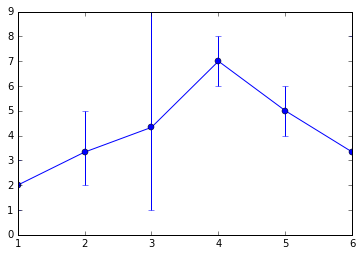

In [340]:
import matplotlib.pyplot as plt
x = [1,2,3,4,5,6]
y = [[1,2,3],[2,3,5],[1,3,9],[6,8,7],[5,4,6],[8,2,0]]
y_mean = [np.mean(l) for l in y]
y_floor = [np.mean(l)-np.min(l) for l in y]
y_ceil = [np.max(l)-np.mean(l) for l in y]
y_err = [np.var(l) for l in y]
plt.errorbar(x,y_mean,yerr=[y_floor,y_ceil],fmt='-o')

In [334]:
np.mean([1,2])

1.5

In [298]:
new1 = re.sub('-LRB-','(',my_sent)
new2 = re.sub('-RRB-',')',new1)
new2

"This cute girl in a pink shirt ( I 'm not sure if this was intentional but she matched some of the macaroons and gelato ) waited on me ."

In [278]:
X_src_ct.shape, X_tar_ct.shape, X_test_ct.shape, 

((1394, 1076), (194, 1076), (12, 1076))

In [270]:
X_ct.shape, nsrc_sents, ntar_sents

((1600, 1076), 1394, 194)

In [241]:
X_smp_ct,X_smp_tf,smp_lbs = get_samples(X_tar_ct,X_tar_tf,all_tar_labels,0.9)

IndexError: list index out of range

In [174]:
len(np.array(CFRF_pred200)[:,0])

NameError: name 'CFRF_pred200' is not defined

In [151]:
test_pd = pd.DataFrame(CFRF_pred[0],columns=['CFRF']).rename({0:108,1:109,2:110})
test_pd

,CFRF
108,0.283
109,0.063
110,0.266


In [169]:
row.iloc[0].to_dict()

{'amt_effect_mean': 0.19999999999999973,
 'amt_effect_median': 0.0,
 'amt_effect_mostcom': -0.5,
 'csf_effect': 0.49689,
 'ctf_effect': 0.45440999999999998,
 'id': 1867234,
 'knn_effect': 0.40000000000000002,
 'source': 'belongings',
 'src_ratings': '[2, 3, 3, 3, 4, 4, 4, 4, 4, 5]',
 'src_sentence': "This company should change their name to ` No Longer Starving ' , because the customers will pay ANY amount just to get their belongings back .",
 'tar_ratings': '[3, 3, 3, 3, 4, 4, 4, 4, 5, 5]',
 'tar_sentence': "This company should change their name to ` No Longer Starving ' , because the customers will pay ANY amount just to get their properties back .",
 'target': 'properties',
 'true_y': 0,
 'vt_effect': 0.087720000000000006}

In [152]:
pd.concat([row,test_pd],axis=1)

,source,target,src_sentence,tar_sentence,knn_effect,vt_effect,ctf_effect,csf_effect,true_y,id,src_ratings,tar_ratings,amt_effect_mean,amt_effect_median,amt_effect_mostcom,CFRF
108,belongings,properties,This company should change their name to ` No ...,This company should change their name to ` No ...,0.40000,0.08772,0.45441,0.49689,0,1867234,"[2, 3, 3, 3, 4, 4, 4, 4, 4, 5]","[3, 3, 3, 3, 4, 4, 4, 4, 5, 5]",0.2,0.0,-0.5,0.283
109,belongings,properties,You can store your belongings in a locker .,You can store your properties in a locker .,0.16667,0.05213,0.17848,0.11292,0,1867247,"[2, 3, 3, 3, 3, 4, 4, 4, 5, 5]","[3, 3, 3, 3, 3, 3, 4, 4, 4, 5]",-0.1,-0.5,0.0,0.063
110,belongings,properties,After two hours of putting up a fuss about my ...,After two hours of putting up a fuss about my ...,0.26667,0.10390,0.29366,0.28979,0,1867252,"[1, 1, 2, 3, 3, 3, 3, 4, 4, 4]","[1, 1, 2, 2, 3, 3, 3, 4, 4, 5]",0.0,0.0,0.0,0.266


### Possible imporvement
- Increase minimal node size
- Print total number of containing sentences for each source and target word
- plot error bar

In [5]:
['a','b','c']+['d','e','f']

['a', 'b', 'c', 'd', 'e', 'f']